In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def signal(fs, freq, duration):
    """
    Complex exponential signal
    """
    t = np.arange(0, duration, 1/fs)
    x = np.exp(2j * np.pi * freq * t)
    return x.reshape(1, -1)  # (1, samples)


def steering_vector(Nr, d, theta_deg):
    """
    ULA steering vector
    """
    theta = np.deg2rad(theta_deg)
    n = np.arange(Nr)
    return np.exp(2j * np.pi * d * n * np.sin(theta))


In [6]:
# Demo parameters

fs = 48e3
freq = 1e3
duration = 0.1
num_samps = int(fs * duration)

Nr = 3
d = 0.5                   # inter-element spacing (λ units)
theta_true = 30           # true DOA in degrees
snr = 10                  # dB

In [9]:
### Signal and array data ###

# Source signal
x = signal(fs, freq, duration)

# Steering vector for true DOA
s = steering_vector(Nr, d, theta_true).reshape(-1, 1)

# Array data (Nr x samples)
X = s @ x

# Add complex white Gaussian noise
signal_power = np.mean(np.abs(X)**2)
noise_power = signal_power / (10**(snr/10))

noise = np.sqrt(noise_power/2) * (
    np.random.randn(Nr, num_samps) +
    1j * np.random.randn(Nr, num_samps)
)

X += noise


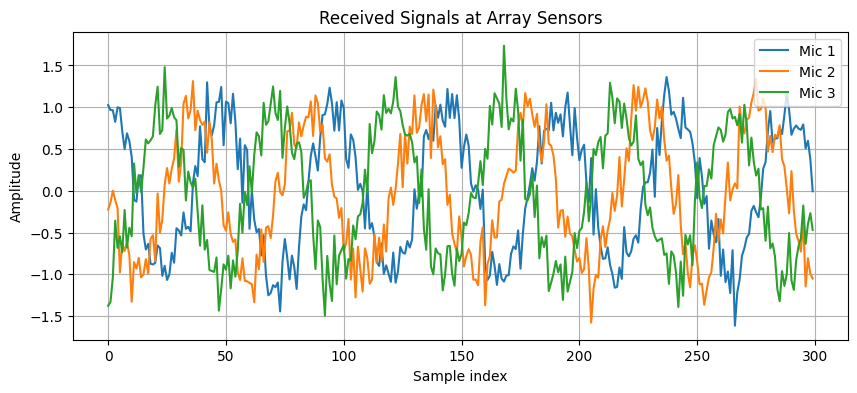

In [10]:
### Time-domain sensor signals

plt.figure(figsize=(10,4))
for i in range(Nr):
    plt.plot(X[i, :300].real, label=f"Mic {i+1}")
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.title("Received Signals at Array Sensors")
plt.grid(True)
plt.show()

In [11]:
### Spatial covariance matrix

# Sample covariance matrix
R = (X @ X.conj().T) / X.shape[1]

# Diagonal loading for numerical stability
delta = 1e-2
R_loaded = R + delta * np.eye(Nr)

R_inv = np.linalg.inv(R_loaded)

DAS DOA estimate: 30.0 degrees


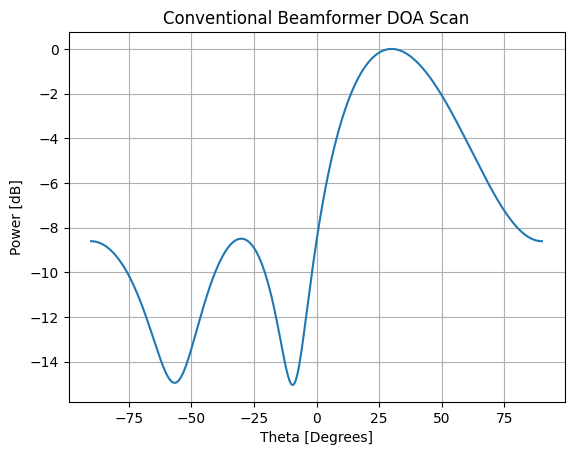

In [14]:
## Conventional (delay-and-sum) DOA scan

theta_scan = np.linspace(-90, 90, 1000)
P_das = []

for theta in theta_scan:
    s_theta = steering_vector(Nr, d, theta).reshape(-1,1)
    y = s_theta.conj().T @ X
    P_das.append(np.var(y))

P_das = 10*np.log10(P_das)
P_das -= np.max(P_das)

print("DAS DOA estimate:",
      theta_scan[np.argmax(P_das)], "degrees")

# Plot DOA
plt.figure()
plt.plot(theta_scan, P_das)
plt.xlabel("Theta [Degrees]")
plt.ylabel("Power [dB]")
plt.title("Conventional Beamformer DOA Scan")
plt.grid(True)
plt.show()


In [15]:
### MVDR Beamformer (Known DOA) ###

s_look = steering_vector(Nr, d, theta_true).reshape(-1,1)

w_mvdr = (R_inv @ s_look) / (s_look.conj().T @ R_inv @ s_look)

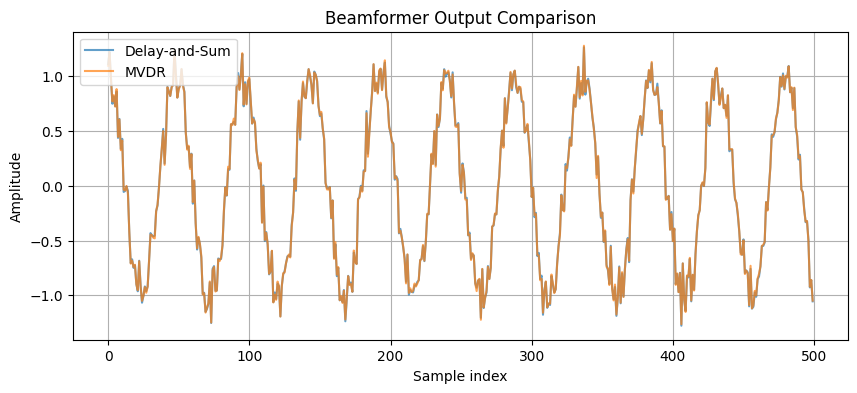

In [17]:
# Apply beamformer

y_mvdr = w_mvdr.conj().T @ X

# Plot time-domain comparison
w_das = s_look / Nr
y_das = w_das.conj().T @ X

plt.figure(figsize=(10,4))
plt.plot(y_das.real.flatten()[:500], label="Delay-and-Sum", alpha=0.7)
plt.plot(y_mvdr.real.flatten()[:500], label="MVDR", alpha=0.7)
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.title("Beamformer Output Comparison")
plt.grid(True)
plt.show()


In [18]:
# MVDR Spatial Spectrum (DOA estimate)
# P_mvdr(theta) = 1/(s^h(theta))(R^-1)(s^h)  --> h = Hermitian

P_mvdr = []

for theta in theta_scan:
    s_theta = steering_vector(Nr, d, theta).reshape(-1,1)
    denom = s_theta.conj().T @ R_inv @ s_theta
    P_mvdr.append(1 / np.abs(denom)[0,0])

P_mvdr = 10*np.log10(P_mvdr)
P_mvdr -= np.max(P_mvdr)

print("MVDR DOA estimate:",
      theta_scan[np.argmax(P_mvdr)], "degrees")


MVDR DOA estimate: 30.0 degrees


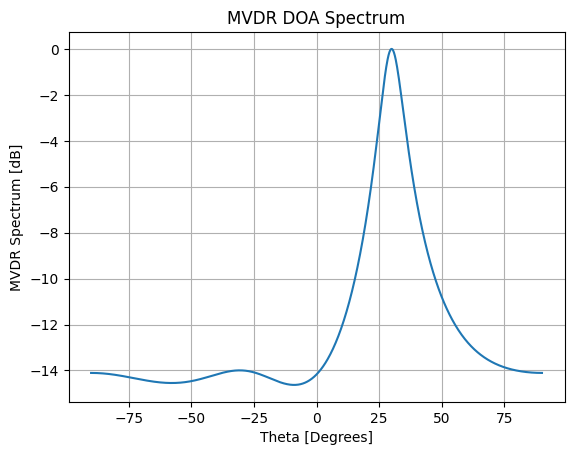

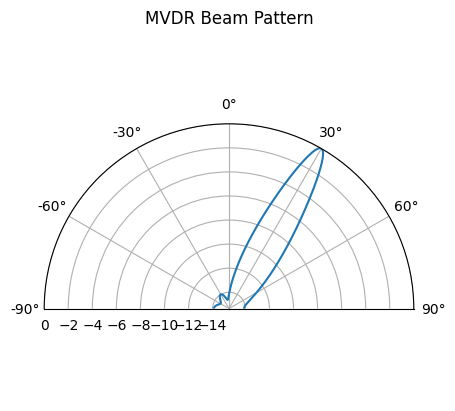

In [19]:
# Plot MVDR

#Cartesian
plt.figure()
plt.plot(theta_scan, P_mvdr)
plt.xlabel("Theta [Degrees]")
plt.ylabel("MVDR Spectrum [dB]")
plt.title("MVDR DOA Spectrum")
plt.grid(True)
plt.show()

#Polar
theta_rad = np.deg2rad(theta_scan)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_rad, P_mvdr)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_rlabel_position(55)
plt.title("MVDR Beam Pattern")
plt.show()
